Go to <a href=#bookmark>my bookmark</a>

In [1]:
import time

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# train, test, validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# preprocessing
from sklearn.preprocessing import MinMaxScaler


In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
combine = [train_df, test_df]

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# del Ticket, Cabin columns
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


# add title

In [6]:
# add title

for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Sir           1
Mme           1
Ms            1
Lady          1
Countess      1
Jonkheer      1
Capt          1
Don           1
Name: Title, dtype: int64

# try one hote encoding without delete rare title

In [7]:
# try one hote encoding without delete rare title
#
# concat train and test data. and apply get_dummies for Title. 
# then split to original size. also drop Survived column from test_df
print(train_df.shape, test_df.shape)

# concat train and test data
#   test_df's Survived column is filled with NaN
train_test_df = pd.concat((train_df, test_df))

print(train_test_df.shape)

# apply get_dummies for Title
train_test_df = pd.get_dummies(train_test_df, columns=["Title"])

#train_test_df.head()
train_df = train_test_df.iloc[:train_df.shape[0]]
test_df = train_test_df.iloc[train_df.shape[0]:]

# drop added Survived column from test_df
test_df = test_df.drop("Survived", axis=1)
print(train_df.shape, test_df.shape)


(891, 11) (418, 10)
(1309, 11)
(891, 28) (418, 27)


In [8]:
test_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Title_Capt,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,34.5,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,0,...,0,0,0,0,0,1,0,0,0,0
1,47.0,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,0,...,0,0,0,0,0,0,1,0,0,0
2,62.0,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,0,...,0,0,0,0,0,1,0,0,0,0
3,27.0,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,0,...,0,0,0,0,0,1,0,0,0,0
4,22.0,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,0,...,0,0,0,0,0,0,1,0,0,0


# del rare title and map value

In [9]:
# del rare title and map value
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,...,0,0,0,0,0,1,0,0,0,0


# drop Name, PassengerId

In [10]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,S,7.2500,0,3,male,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,C,71.2833,0,1,female,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,S,7.9250,0,3,female,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,S,53.1000,0,1,female,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,S,8.0500,0,3,male,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# map value to Sex 

In [11]:
for dataset in combine:
    dataset["Sex"] = dataset["Sex"].map({'female':1, 'male':0}).astype(int)
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22.0,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38.0,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26.0,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35.0,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35.0,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# fill na value

In [12]:
train_df.isna().any()

Age                True
Embarked           True
Fare              False
Parch             False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

In [13]:
test_df.isna().any()

Age                True
Embarked          False
Fare               True
Parch             False
PassengerId       False
Pclass            False
Sex               False
SibSp             False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

## fill na of Age

In [14]:
guess_ages = np.zeros((2,3))

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,22,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,38,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,26,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,35,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,35,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
train_df.isna().any()

Age               False
Embarked           True
Fare              False
Parch             False
Pclass            False
Sex               False
SibSp             False
Survived          False
Title_Capt        False
Title_Col         False
Title_Countess    False
Title_Don         False
Title_Dona        False
Title_Dr          False
Title_Jonkheer    False
Title_Lady        False
Title_Major       False
Title_Master      False
Title_Miss        False
Title_Mlle        False
Title_Mme         False
Title_Mr          False
Title_Mrs         False
Title_Ms          False
Title_Rev         False
Title_Sir         False
dtype: bool

### tried keep Age feature and don't add AgeBand numerical feature
if both are there, it is duplicate information

### 2018/03/17 tried Age instead of Age band. But AgeBand is better score for almost all models.
svc score was same of little bit better.
random forest score became worse.
so AgeBand is better

## add age band

In [16]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,AgeBand
0,22,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,"(16.0, 32.0]"
1,38,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
2,26,S,7.9250,0,3,1,0,1.0,0,0,...,0,1,0,0,0,0,0,0,0,"(16.0, 32.0]"
3,35,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,1,0,0,0,"(32.0, 48.0]"
4,35,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,1,0,0,0,0,"(32.0, 48.0]"


## Overwrite AgeBand number on Age. means, drop Age and AgeBand text column

In [17]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir
0,1,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0


# Create new feature

In [18]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass
    

train_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title_Capt,Title_Col,...,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,FamilySize,IsAlone,Age*Class
0,1,S,7.2500,0,3,0,1,0.0,0,0,...,0,0,1,0,0,0,0,2,0,3
1,2,C,71.2833,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,2,0,2
2,1,S,7.9250,0,3,1,0,1.0,0,0,...,0,0,0,0,0,0,0,1,1,3
3,2,S,53.1000,0,1,1,1,1.0,0,0,...,0,0,0,1,0,0,0,2,0,2
4,2,S,8.0500,0,3,0,0,0.0,0,0,...,0,0,1,0,0,0,0,1,1,6


# drop Parch, SibSp, FaimilySize

## todo : think more about these features

In [19]:
# drop Parch, SibSp, FaimilySize

train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Title_Capt,Title_Col,Title_Countess,Title_Don,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,IsAlone,Age*Class
0,1,S,7.2500,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
1,2,C,71.2833,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,1,S,7.9250,3,1,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3
3,2,S,53.1000,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
4,2,S,8.0500,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,6


# fill missing Embarked 

In [20]:
freq_port = train_df.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)


# Converting Embarked categorical feature to numeric

## todo : try one hot encoding

In [21]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,Title_Capt,Title_Col,Title_Countess,Title_Don,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,IsAlone,Age*Class
0,1,0,7.2500,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
1,2,1,71.2833,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,1,0,7.9250,3,1,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3
3,2,0,53.1000,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
4,2,0,8.0500,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,6


# fill na of test data Fare

In [22]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Title_Capt,Title_Col,Title_Countess,Title_Don,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,IsAlone,Age*Class
0,2,2,7.8292,892,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,6
1,2,0,7.0000,893,3,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6
2,3,2,9.6875,894,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,6
3,1,0,8.6625,895,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
4,1,0,12.2875,896,3,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3


# make Fareband feature

## todo : try more fare band number
## todo : keep Fare feature and add FareBand numerical feature¶

In [23]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]
    
train_df.head(10)

,Age,Embarked,Fare,Pclass,Sex,Survived,Title_Capt,Title_Col,Title_Countess,Title_Don,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,IsAlone,Age*Class
0,1,0,0,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
1,2,1,3,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
2,1,0,1,3,1,1.0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3
3,2,0,3,1,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
4,2,0,1,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,6
5,1,2,1,3,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
6,3,0,3,1,0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
7,0,0,2,3,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,1,3,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
9,0,1,2,2,1,1.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


----

# model and estimate

## try several models

In [24]:
X_train_df = train_df.drop("Survived", axis=1)
y_train_df = train_df["Survived"]

X_test_df = test_df.drop("PassengerId", axis=1).copy()

In [25]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_train_df, y_train_df)
scores.mean()

0.7923681257014591

In [26]:
scores

array([0.77441077, 0.80808081, 0.79461279])

In [27]:
# cannnot get model attribute because of cross_val_score use
"""
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)
"""

'\ncoeff_df = pd.DataFrame(train_df.columns.delete(0))\ncoeff_df.columns = [\'Feature\']\ncoeff_df["Correlation"] = pd.Series(logreg.coef_[0])\n\ncoeff_df.sort_values(by=\'Correlation\', ascending=False)\n'

In [28]:
svc = SVC(C=10.0, kernel="rbf")
scores = cross_val_score(svc, X_train_df, y_train_df)
scores.mean()

0.8125701459034792

In [29]:
gaussianNb = GaussianNB()
scores = cross_val_score(gaussianNb, X_train_df, y_train_df)
scores.mean()

0.6778900112233446

In [30]:
perceptron = Perceptron()
scores = cross_val_score(perceptron, X_train_df, y_train_df)
scores.mean()

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/skle

0.6150392817059483

In [31]:
linear_svc = LinearSVC()
scores = cross_val_score(linear_svc, X_train_df, y_train_df)
scores.mean()

0.8035914702581369

In [32]:
sgd = SGDClassifier()
scores = cross_val_score(sgd, X_train_df, y_train_df)
scores.mean()

/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/yuki/.local/lib/pyth

0.6285072951739618

In [33]:
decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, X_train_df, y_train_df)
scores.mean()

0.7946127946127947

In [34]:
random_forest = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(random_forest, X_train_df, y_train_df)
scores.mean()

0.7991021324354658

----

# make train, test data set from train.csv

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_train_df, test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)

train/test data shape (596, 25) (295, 25)


train 0.8137765275601765
best scroe:  0.8221476510067114
best estimator: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test:  0.8101694915254237


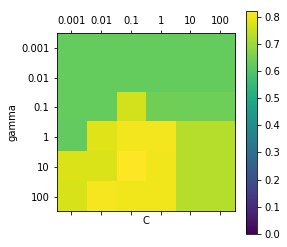

In [36]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

#param_grid = [{'kernel': ['rbf'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
#              {'kernel': ['linear'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
#grid_search.fit(X_train, y_train)

scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print("train", scores.mean())

# cannot show grid_search attribute because using cross_val_score
#print(grid_search.score(X_train, y_train))
#print(grid_search.best_params_)




# to get cv_results_, need to fit with data once

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(6, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()


print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

train 0.8155139343873141
best scroe:  0.8288590604026845
best estimator: SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test:  0.8


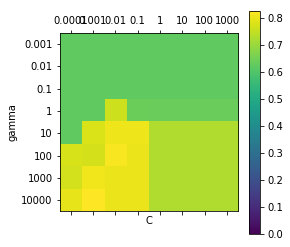

In [37]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print("train", scores.mean())


# to get cv_results_, need to fit with data once

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

train 0.8070398328823055
best scroe:  0.8070469798657718
best estimator: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test:  0.8067796610169492


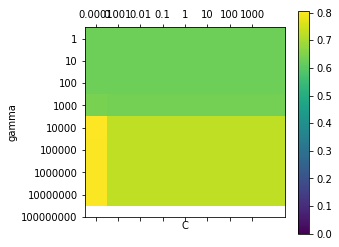

In [38]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print("train", scores.mean())


# to get cv_results_, need to fit with data once

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(8, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

train 0.6275245691496938
best scroe:  0.62751677852349
best estimator: SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
test:  0.5932203389830508


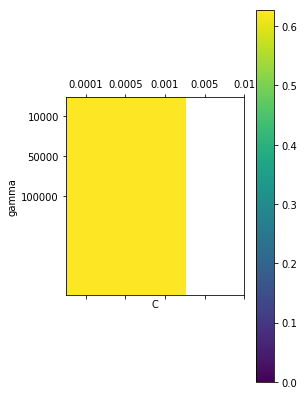

In [39]:
# make wide the ranges

param_grid = {'C': [0.0001, 0.0005, 0.001, 0.005, 0.01],
              'gamma': [10000, 50000, 100000]}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)

scores = cross_val_score(grid_search, X_train, y_train, cv=5)
print("train", scores.mean())



# to get cv_results_, need to fit with data once

grid_search.fit(X_train, y_train)

plt.matshow(grid_search.cv_results_['mean_test_score'].reshape(5, -1),
            vmin=0, cmap="viridis")
plt.xlabel("C")
plt.ylabel("gamma")
plt.xticks(range(len(param_grid['C'])), param_grid['C'])
plt.yticks(range(len(param_grid['gamma'])), param_grid['gamma'])
plt.colorbar()

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("test: ", grid_search.score(X_test, y_test))

----

# apply preprocessing

In [40]:
X_train.head()

,Age,Embarked,Fare,Pclass,Sex,Title_Capt,Title_Col,Title_Countess,Title_Don,Title_Dona,...,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,IsAlone,Age*Class
6,3,0,3,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
718,1,2,2,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,3
685,1,1,3,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
73,1,1,2,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,3
882,1,0,1,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,3


### Min Max Scaler

In [41]:
#minmaxScaler = MinMaxScaler()
#minmaxScaler.fit(X_train)

#X_minmaxScaled = minmaxScaler.transform(X)
#X_minmaxScaled[0]

In [42]:
# grid search SVC
# use cross_val_score

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
#              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

#param_grid = [{'kernel': ['rbf'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100],
#               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
#              {'kernel': ['linear'],
#               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

#grid_search = GridSearchCV(SVC(), param_grid, cv=5)
#grid_search.fit(X_minmaxScaled, y)

#scores = cross_val_score(grid_search, X_minmaxScaled, y, cv=5)
#print("train", scores.mean())

In [43]:
pipe = make_pipeline(MinMaxScaler(), SVC())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7966101694915254

In [44]:
# grid search for pipeline
param_grid = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

pipe = make_pipeline(MinMaxScaler(), SVC())

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("grid search best score", grid.best_score_)
print("test", grid.score(X_test, y_test))
print(grid.best_params_)

grid search best score 0.8204697986577181
test 0.7932203389830509
{'svc__C': 100, 'svc__gamma': 0.1}


In [45]:
# watching wrong result

pipe.fit(X_train, y_train)
print("test", pipe.score(X_test, y_test))

scores = cross_val_score(pipe, X_train_df, y_train_df, cv=5)
print("cross eval for all", scores.mean())

y_predicted = pipe.predict(X_test)

confusion = confusion_matrix(y_test, y_predicted)
print("Confusion matrix:\n{}".format(confusion))

wrongResult = []
for i, (y, y_pred) in enumerate(zip(y_test, y_predicted)):
    if y != y_pred:
        wrongResult.append([X_test.iloc[i,:], y, y_pred])

print(wrongResult[0])
print(wrongResult[1])

test 0.7966101694915254
cross eval for all 0.7856039835632975
Confusion matrix:
[[151  24]
 [ 36  84]]
[Age               1
Embarked          1
Fare              2
Pclass            3
Sex               0
Title_Capt        0
Title_Col         0
Title_Countess    0
Title_Don         0
Title_Dona        0
Title_Dr          0
Title_Jonkheer    0
Title_Lady        0
Title_Major       0
Title_Master      1
Title_Miss        0
Title_Mlle        0
Title_Mme         0
Title_Mr          0
Title_Mrs         0
Title_Ms          0
Title_Rev         0
Title_Sir         0
IsAlone           0
Age*Class         3
Name: 709, dtype: int64, 1.0, 0.0]
[Age               1
Embarked          0
Fare              2
Pclass            3
Sex               1
Title_Capt        0
Title_Col         0
Title_Countess    0
Title_Don         0
Title_Dona        0
Title_Dr          0
Title_Jonkheer    0
Title_Lady        0
Title_Major       0
Title_Master      0
Title_Miss        1
Title_Mlle        0
Title_Mme         0


# random forest result for compare

In [46]:
X_test.shape, y_test.shape

((295, 25), (295,))

In [47]:
param_grid = {'randomforestclassifier__n_estimators': [5, 10, 20, 30, 50, 100, 300],
              'randomforestclassifier__max_features': [1, 'auto', None],
             'randomforestclassifier__max_depth':[1, 5, 10, None],
             'randomforestclassifier__min_samples_leaf': [1,2,4]}

pipe = make_pipeline(MinMaxScaler(), RandomForestClassifier(n_estimators=100))

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print("best scroe: ", grid_search.best_score_)
print("best estimator:", grid_search.best_estimator_)
print("best param:", grid_search.best_params_)
print("test: ", grid_search.score(X_test, y_test))

#scores = cross_val_score(grid_search, X_train_df, y_train_df, cv=5)
#print("cross eval for all", scores.mean())

best scroe:  0.825503355704698
best estimator: Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=N...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
best param: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 20}
test:  0.7932203389830509


In [48]:
test_df_noid = test_df.drop("PassengerId", axis=1).copy()
y_pred = grid_search.predict(test_df_noid).astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('../output/submission_minmaxscaler_ranfore'+ time.strftime("%Y-%m-%d-%H-%M-%S") + '.csv', index=False)

# todo

- [ ] try grid search
- [ ] other model
- [ ] make preprocessing
- [ ] think train/test/validation data
- 
